In [1]:
!pip install opendatasets

In [16]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import  Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import opendatasets as od
from tensorflow.keras.utils import plot_model

In [3]:
#upload the data into colab

od.download("https://www.kaggle.com/datasets/itamargr/dfdc-faces-of-the-train-sample")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mustafaarahim
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/itamargr/dfdc-faces-of-the-train-sample


100%|██████████| 3.64G/3.64G [00:53<00:00, 72.7MB/s]


In [4]:
ig = ImageDataGenerator(rescale=1./255.)
train_flow = ig.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/train',
    target_size=(160, 160),
    batch_size=100,
    class_mode='categorical',

)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/validation',
    target_size=(160, 160),
    batch_size=100,
    class_mode='categorical',

)

test_flow = ig.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/validation',
    target_size=(160, 160),
    batch_size=100,
    shuffle = False,
    class_mode='categorical',
)

train_flow.class_indices

Found 93853 images belonging to 2 classes.
Found 30794 images belonging to 2 classes.
Found 30794 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [7]:
def build_model():
    densenet = Xception(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(160,160,3)
                        )
    model = Sequential([densenet,

                        layers.GlobalAveragePooling2D(),
                        layers.Dense(1024, activation = 'relu'),
                        layers.BatchNormalization(),
                         layers.Dense(256, activation = 'relu'),
                        layers.BatchNormalization(),


                        layers.Dense(2, activation='softmax')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [8]:
model=build_model()
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                         

In [9]:
checkpoint = ModelCheckpoint(filepath='model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=1,
                              verbose=1,
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [10]:
history = model.fit(train_flow,
    epochs = 5,
    validation_data =valid_flow,
    callbacks=callbacks
)

Epoch 1/5
939/939 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9538
Epoch 1: val_loss improved from inf to 0.53155, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


939/939 [==============================] - 882s 895ms/step - loss: 0.1270 - accuracy: 0.9538 - val_loss: 0.5316 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 2/5
939/939 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9801
Epoch 2: val_loss improved from 0.53155 to 0.47020, saving model to model.h5
939/939 [==============================] - 822s 875ms/step - loss: 0.0509 - accuracy: 0.9801 - val_loss: 0.4702 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 3/5
939/939 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9847
Epoch 3: val_loss did not improve from 0.47020

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
939/939 [==============================] - 815s 868ms/step - loss: 0.0380 - accuracy: 0.9847 - val_loss: 0.4819 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 4/5
939/939 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9962
Epoch 4: val_loss did not improve from 0.47020

Epoch 4: ReduceLROnPl

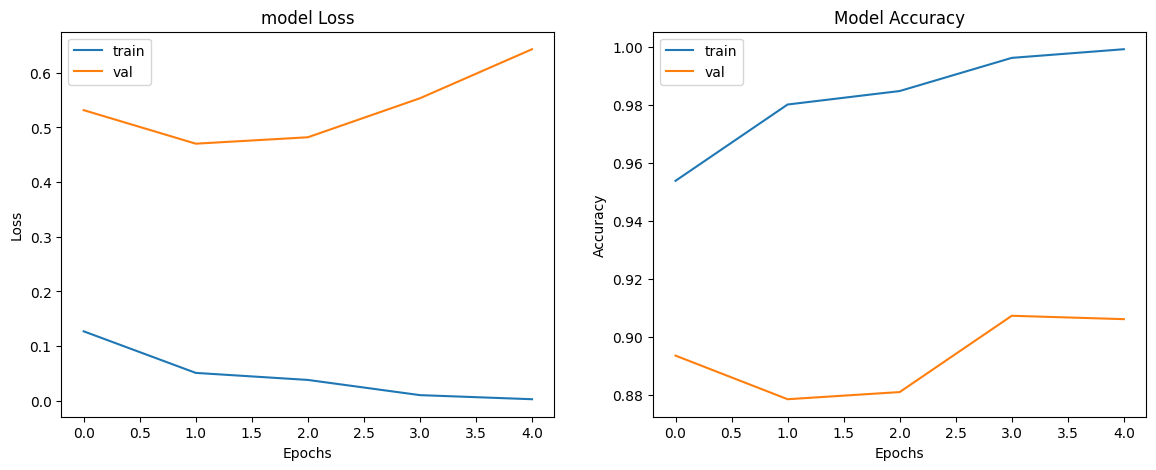

In [11]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.show()

In [12]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

308/308 [==============================] - 68s 219ms/step


In [13]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [17]:
confusion_matrix=confusion_matrix(y_test, y_pred_labels)
confusion_matrix

array([[22974,  1791],
       [ 1101,  4928]])

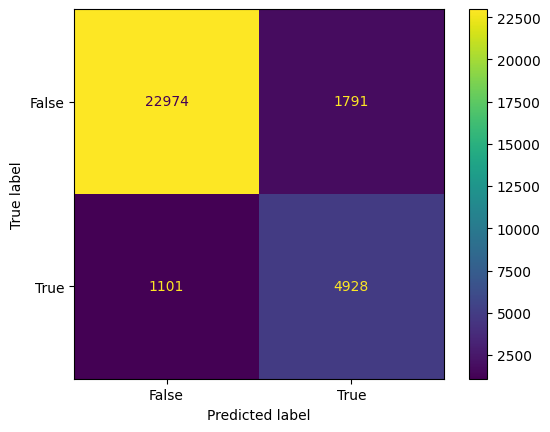

In [18]:
Fake=False
Real=True

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [Fake, Real])

cm_display.plot()
plt.show()

In [19]:
_, accu = model.evaluate(test_flow)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

308/308 [==============================] - 66s 214ms/step - loss: 0.6430 - accuracy: 0.9061
Final Test Acccuracy = 90.609


In [20]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_labels))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_labels))
print()
print(metrics.classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.8725314221722005
AP Score: 0.6352568737523764

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     24765
           1       0.73      0.82      0.77      6029

    accuracy                           0.91     30794
   macro avg       0.84      0.87      0.86     30794
weighted avg       0.91      0.91      0.91     30794



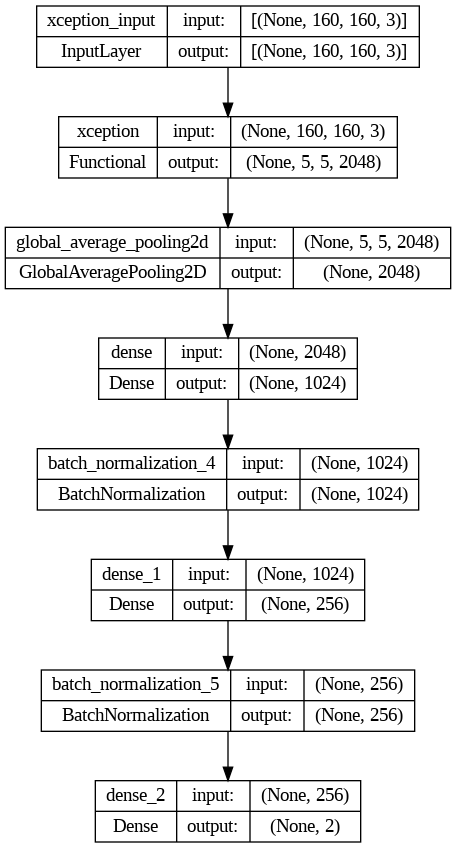

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)